In [1]:

from comet_ml import Experiment
import GPUtil
import torch

import os
import codecarbon
from iesta.machine_learning.dataloader import IESTAData, LABELS
from iesta.machine_learning.huggingface_loader import IESTAHuggingFace
from nlpaf.transformers.text_classification import TextClassification
from dotenv import load_dotenv, find_dotenv
import argparse
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict


/home/elba_ro/repos/github/conf22-style-transfer/iesta_venv/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [11]:
import re

import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
def _apply_no_punc(row):
    row["text_no_punc"] = re.sub(r'[^\w\s]', '', row["text"])
    return row

def profile_datasets(ds_name:str = "debateorg_w_effect_for_liberal", lower:bool = False):
    dataset_dict: DatasetDict = load_dataset(f"notaphoenix/{ds_name}")
    dfs = []
    for split, ds in dataset_dict.items():
        print(split)
        dfs.append(ds.to_pandas())

    df = pd.concat(dfs)
    len(df)
        #profile = ProfileReport(df, title="Profiling Report")
    #df["text_low"] = df["text"].str.lower()
    dissmiss_arr = []
    with open("../data/dismiss_text.txt", "r") as dismissedf:
        dissmiss_arr = list(pd.Series(dismissedf.read().splitlines()).str.lower())
        dissmiss_arr = list(set([re.sub(r'[^\w\s]', '', x) for x in dissmiss_arr]))
    
    
    df = df.apply(_apply_no_punc, axis=1)
    df = df[~df["text_no_punc"].str.lower().isin(dissmiss_arr)]
    if lower:
        df["text_low"] = df["text"].str.lower()
        profile = ProfileReport(df[["text_low"]], title="Profiling Report")
        profile.to_file(f"../data/profilers/{ds_name}_low.html")
    else:
        profile = ProfileReport(df[["text"]], title="Profiling Report")
        profile.to_file(f"../data/profilers/{ds_name}.html")
    return df, profile

In [12]:
# This is typically needed once per notebook
#%matplotlib inline 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize

sns.set(style="darkgrid")
import re


In [34]:
def plot_datasets(ds_name:str = "debateorg_w_effect_for_liberal", lower:bool = False):
    dataset_dict: DatasetDict = load_dataset(f"notaphoenix/{ds_name}")
    dfs = []
    for split, ds in dataset_dict.items():
        print(split)
        dfs.append(ds.to_pandas())

    df = pd.concat(dfs)
    len(df)
        #profile = ProfileReport(df, title="Profiling Report")
    #df["text_low"] = df["text"].str.lower()
    dissmiss_arr = []
    with open("../data/dismiss_text.txt", "r") as dismissedf:
        dissmiss_arr = list(pd.Series(dismissedf.read().splitlines()).str.lower())
        dissmiss_arr = list(set([re.sub(r'[^\w\s]', '', x) for x in dissmiss_arr]))
    
    
    df = df.apply(_apply_no_punc, axis=1)
    df = df[~df["text_no_punc"].str.lower().isin(dissmiss_arr)]

    df['num_tokens'] = df['text'].apply(lambda x: len(word_tokenize(x)))
    df['num_chars'] = df['text'].apply(lambda x: len(x))

    #df = df[df['num_tokens']>2]
    #df = df[df['num_tokens']<=1600]
    sns.set(style="darkgrid")
    fig, axes = plt.subplots(figsize=(10,7))
    # Plot histogram
    color="olive"
    for lbl, df_ in df.groupby(['label']):
        sns.histplot(df_['num_chars'], bins=50, color=color, label=lbl, stat="percent")
        color = "skyblue"

    plt.title(f'Histogram of Token Counts {ds_name} ')
    plt.xlabel("Number of Tokens")
    plt.ylabel("Frequency")
    plt.legend() 
    plt.show()
    return df
    

Found cached dataset parquet (/home/elba_ro/.cache/huggingface/datasets/notaphoenix___parquet/notaphoenix--debateorg_w_effect_for_liberal_subset-2510e01b5ef739a4/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

validation
test
training


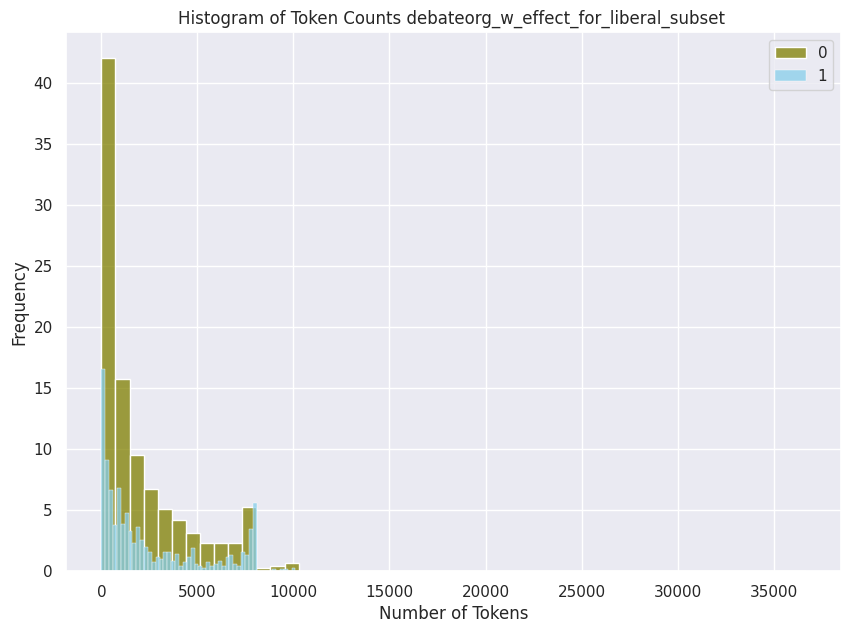

In [43]:
lib = plot_datasets( "debateorg_w_effect_for_liberal_subset")




In [48]:
for lbl, df_ in lib.groupby(['label']):
    print(lbl)
    prev = 0
    for x in range(5,2001,295):
        print(f"between {prev} and {x} (inclusive): ", len(df_[(df_['num_tokens']> prev) & (df_['num_tokens']<= x)]))
        prev = x
    print(f"<= 600: ", len(df_[(df_['num_tokens']<= 600)]))
    print(f"> 600: ", len(df_[(df_['num_tokens']> 600)]))
for lbl, df_ in lib.groupby(['label']):
    print(lbl)
    prev = 0
    for x in range(20, 10000,500):
        print(f"between {prev} and {x} (inclusive): ", len(df_[(df_['num_tokens']> prev) & (df_['num_tokens']<= x)]))
        prev = x    

0
between 0 and 5 (inclusive):  362
between 5 and 300 (inclusive):  8779
between 300 and 595 (inclusive):  2535
between 595 and 890 (inclusive):  1482
between 890 and 1185 (inclusive):  872
between 1185 and 1480 (inclusive):  828
between 1480 and 1775 (inclusive):  763
<= 600:  11705
> 600:  4093
1
between 0 and 5 (inclusive):  17
between 5 and 300 (inclusive):  341
between 300 and 595 (inclusive):  115
between 595 and 890 (inclusive):  57
between 890 and 1185 (inclusive):  41
between 1185 and 1480 (inclusive):  43
between 1480 and 1775 (inclusive):  75
<= 600:  473
> 600:  220
0
between 0 and 20 (inclusive):  1623
between 20 and 520 (inclusive):  9567
between 520 and 1020 (inclusive):  2397
between 1020 and 1520 (inclusive):  1437
between 1520 and 2020 (inclusive):  716
between 2020 and 2520 (inclusive):  48
between 2520 and 3020 (inclusive):  0
between 3020 and 3520 (inclusive):  1
between 3520 and 4020 (inclusive):  2
between 4020 and 4520 (inclusive):  1
between 4520 and 5020 (incl

Found cached dataset parquet (/home/elba_ro/.cache/huggingface/datasets/notaphoenix___parquet/notaphoenix--debateorg_w_effect_for_liberal_subset-2510e01b5ef739a4/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

validation
test
training


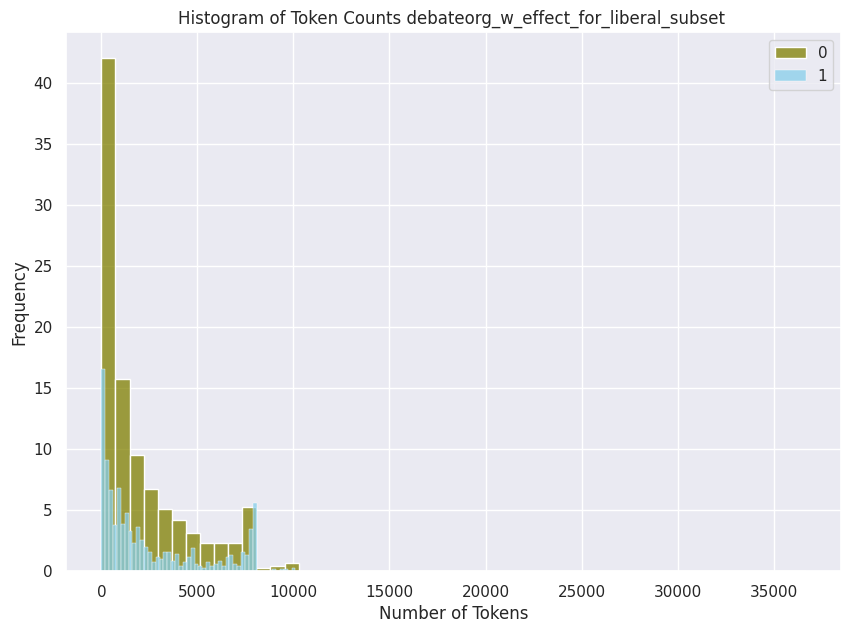

In [47]:
dataset_names = ["debateorg_w_effect_for_liberal_subset",
                 "debateorg_w_effect_for_conservative_subset",
                 "debateorg_w_effect_for_liberal",
                 "debateorg_w_effect_for_conservative"]



for ds_name in dataset_names:
    #profile_datasets(ds_name, lower=True)
    plot_datasets(ds_name)
    break
    